In [26]:
from f_drosophila_infer import *
from f_train import *
from f_data_prep import *

In [27]:
data_all = np.loadtxt('../data_complete.txt')
# data_all = data_all - np.median(data_all, axis=0)
all_bin = np.vsplit(data_all, 6)
all_init = np.vstack([all_bin[i] for i in range(5)])
all_diff = np.vstack([all_bin[i+1]-all_bin[i] for i in range(5)])

complete_all = ([int(x) - 1 for x in open('../indices_complete.txt','r').readline().split()])
comp_ind = list(map(int, list((np.array(complete_all)[::6]-3)/6)))

data_comp = np.copy(data_all[:, comp_ind])
comp_bin = np.vsplit(data_comp, 6)
comp_init = np.vstack([comp_bin[i] for i in range(5)])
comp_diff = np.vstack([comp_bin[i+1] - comp_bin[i] for i in range(5)])

In [28]:
all_init, all_diff, comp_init, comp_diff = shuffle(all_init, all_diff, comp_init, comp_diff)

In [29]:
# def ER_cv(X, y, gene_comp=[], kf=10, power_=1):
#     kfold = KFold(n_splits=kf, shuffle=False, random_state=1)
    
#     error_list=[]
#     for (tr, te) in (kfold.split(y)):
#         X_tr, y_tr = X[tr], y[tr]
#         X_te, y_te = X[te], y[te]
        
#         if y.shape[1] == len(gene_comp):
#             X_init = np.copy(X_te[:, comp_ind])
#         else:
#             X_init = np.copy(X_te)
            
#         y_actual = X_init + y_te   
#         y_actual_sum_sq = np.sum(np.abs(y_actual)**2, axis=0)
        
#         w, sigma, bias = infer_drosophila(X_tr, y_tr, max_iter=1000, power=power_, l=10)
#         noise = sigma*npr.normal(size=(1, w.shape[1]))
            
#         if power_ == 0:
#             y_pred = X_init + (np.tanh(bias + X_te.dot(w)) + noise)
#         if power_ == 1:
#             y_pred = X_init + (bias + X_te.dot(w) + noise)
#         if power_ == 3:
#             y_pred = X_init + (odd_power(bias + X_te.dot(w), power_) + noise)
                
#         error = np.sqrt(np.sum(np.abs(y_actual - y_pred)**2, axis=0)/y_actual_sum_sq)
#         error_list.append(error)
#     return [np.mean(error_list, axis=0), np.std(error_list, axis=0)]

# def infer_all_ER(X_all, X_comp, y_all, y_comp, func=1):
#     res=[]
#     results = ER_cv(X_all, y_all, gene_comp=comp_ind, kf=10, power_=func)
#     res.append(results)
#     results = ER_cv(X_all, y_comp, gene_comp=comp_ind, kf=10, power_=func)
#     res.append(results)
#     results = ER_cv(X_comp, y_comp, gene_comp=[], kf=10, power_=func)
#     res.append(results)
#     return res

In [30]:
from sklearn import linear_model
def skl_cv(X, y, gene_comp=[], kf=10):
    kfold = KFold(n_splits=kf, shuffle=False)
    
    if len(gene_comp) > 0:
        X_in = np.copy(X[:, comp_ind])
    else:
        X_in = np.copy(X)
        
    error_list=[]
    w_list = []
    bias_list = []
    yp_list = []
    for (cell_tr, cell_te) in (kfold.split(range(6078))):
#         print(len(cell_tr), len(cell_te))
        te = np.hstack([cell_te+(6078*i) for i in range(5)])
        tr = np.hstack([cell_tr+(6078*i) for i in range(5)])
        X_tr, y_tr = X_in[tr], y[tr]
        X_te, y_te = X_in[te], y[te]
        
        regr = linear_model.LinearRegression()
        regr.fit(X_tr, y_tr)
        w_list.append(regr.coef_.T)
        bias_list.append(regr.intercept_)
        
        if y.shape[1] == 27:
            X_init = np.copy(X[:, comp_ind][te])
        else:
            X_init = np.copy(X[te])
            
        y_actual = X_init + y_te
        y_actual_sum_sq = np.sum(np.abs(y_actual)**2, axis=0)
        
        y_pred = X_init + regr.predict(X_te)
        yp_list.append(np.copy(y_pred))
#         y_pred[y_pred < 0] = 0
        
        error = (np.sum(np.abs(y_pred - y_actual)**2, axis=0)/y_actual_sum_sq)**(1/2)
        error_list.append(error)
    print(X_init.shape[1], X_te.shape[1], regr.coef_.T.shape)
    return [np.mean(error_list, axis=0), np.std(error_list, axis=0), w_list, bias_list, yp_list]

def infer_all_skl(X_all, y_all, y_comp):
    res=[]
    results = skl_cv(X_all, y_all, gene_comp=[], kf=10)
    res.append(results)
    results = skl_cv(X_all, y_comp, gene_comp=[], kf=10)
    res.append(results)
    results = skl_cv(X_all, y_all, gene_comp=comp_ind, kf=10)
    res.append(results)
    results = skl_cv(X_all, y_comp, gene_comp=comp_ind, kf=10)
    res.append(results)
    return res

In [31]:
# ER_linear = infer_all_ER(all_init, comp_init, all_diff, comp_diff, func=1)
skl_linear = infer_all_skl(all_init, all_diff, comp_diff)
# res_tanh = infer_all(all_init, comp_init, all_diff, comp_diff,  func=1)
# res_oddpower = infer_all(all_init, comp_init, all_diff, comp_diff, func=3)

99 99 (99, 99)
27 99 (99, 27)
99 27 (27, 99)
27 27 (27, 27)


In [25]:
# with open('./pickles/ER_linear.pkl', 'wb') as f:
#     pickle.dump(ER_linear, f)
with open('./pickles/skl_linear_neg.pkl', 'wb') as f:
    pickle.dump(skl_linear, f)
# with open('./pickles/res_tanh.pkl', 'wb') as f:
#     pickle.dump(res_tanh, f)
# with open('./pickles/res_oddpower.pkl', 'wb') as f:
#     pickle.dump(res_oddpower, f)

In [8]:
# with open('./pickles/ER_linear.pkl', 'rb') as f:
#     ER_linear = pickle.load(f)
with open('./pickles/skl_linear.pkl', 'rb') as f:
    skl_linear = pickle.load(f)
# with open('./pickles/res_tanh.pkl', 'rb') as f:
#     res_tanh = pickle.load(f)
# with open('./pickles/res_oddpower.pkl', 'rb') as f:
#     res_oddpower = pickle.load(f)

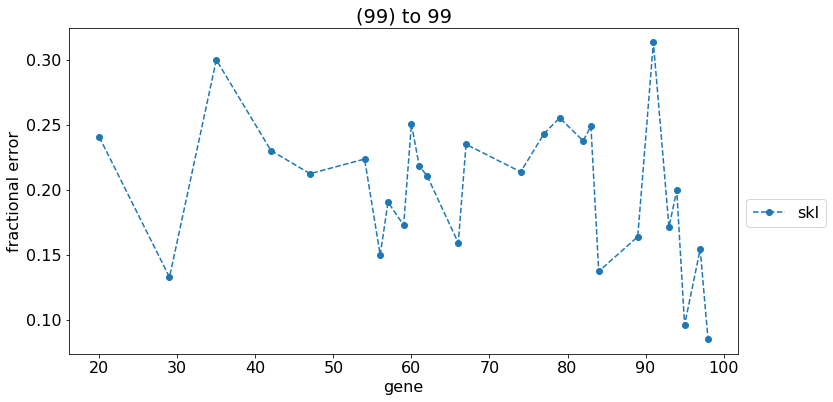

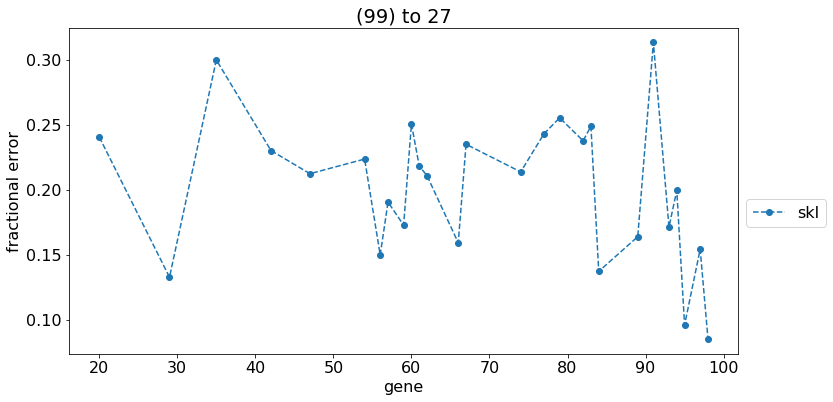

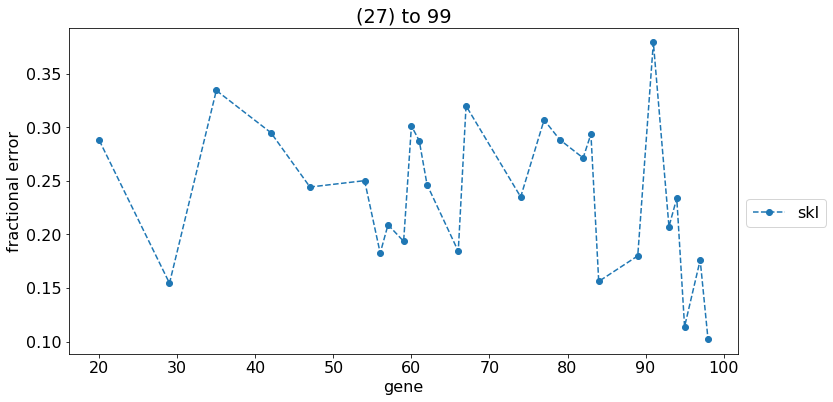

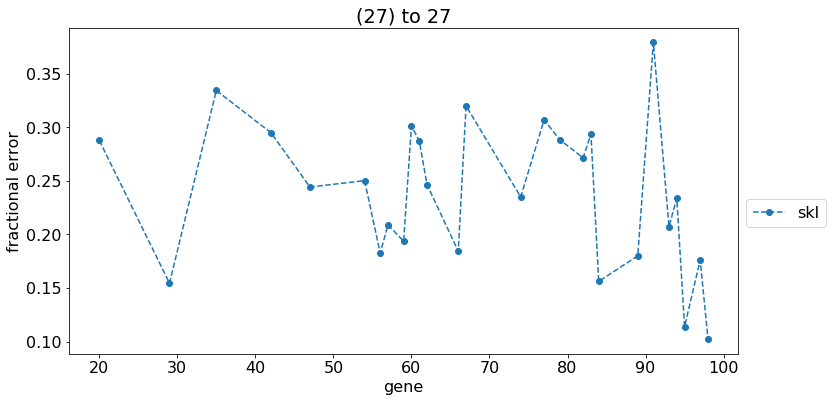

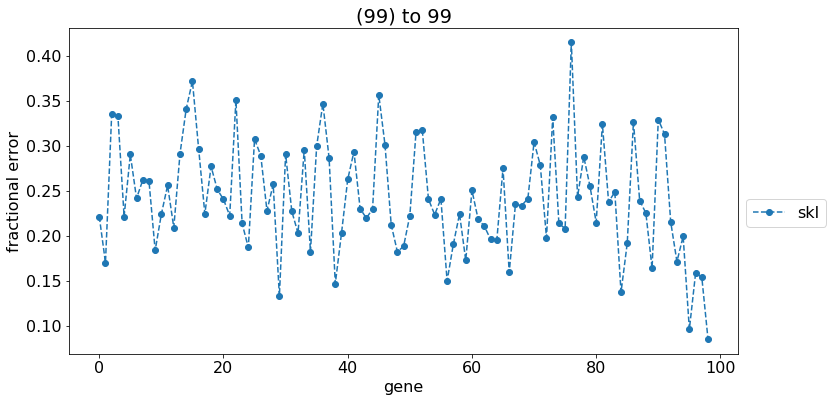

In [9]:
% matplotlib inline
labels=['(99) to 99', '(99) to 27', '(27) to 99', '(27) to 27']
for i in range(4):
    plt.figure(figsize=(12,6))
    if i == 0 or i == 2:
#         plt.plot(comp_ind, ER_linear[i][0][comp_ind], 'o--', label='ER')
        plt.plot(comp_ind, skl_linear[i][0][comp_ind], 'o--', label='skl')
    else:
#         plt.plot(comp_ind, ER_linear[i][0], 'o--', label='ER')
        plt.plot(comp_ind, skl_linear[i][0], 'o--', label='skl')
    plt.title(labels[i])
    plt.legend(bbox_to_anchor=(1,0.5))
    plt.xlabel('gene')
    plt.ylabel('fractional error')
    plt.show()

plt.figure(figsize=(12,6))
# plt.plot(range(99), ER_linear[0][0], 'o--', label='ER')
plt.plot(range(99), skl_linear[0][0], 'o--', label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.title('(99) to 99')
plt.xlabel('gene')
plt.ylabel('fractional error')
plt.show()
# plt.figure(figsize=(12,6))
# for (i, res) in enumerate(res_tanh):
#     if i == 0:
#         plt.plot(comp_ind, res[0][comp_ind], 'o--', label=labels[i])
#     else:
#         plt.plot(comp_ind, res[0], 'o--', label=labels[i])
#     plt.legend(bbox_to_anchor=(1,0.5))
#     plt.title('tanh activation')
#     plt.xlabel('gene')
#     plt.ylabel('fractional error')
    
# plt.figure(figsize=(12,6))
# for (i, res) in enumerate(res_oddpower):
#     if i == 0:
#         plt.plot(comp_ind, res[0][comp_ind], 'o--', label=labels[i])
#     else:
#         plt.plot(comp_ind, res[0], 'o--', label=labels[i])
#     plt.legend(bbox_to_anchor=(1,0.5))
#     plt.title('oddpower activation')
#     plt.xlabel('gene')
#     plt.ylabel('fractional error')

### linear comparison

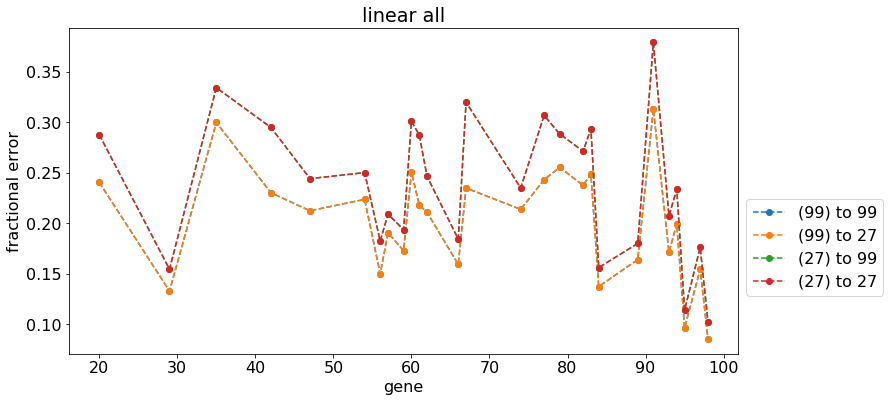

In [10]:
plt.figure(figsize=(12,6))
labels=['(99) to 99', '(99) to 27', '(27) to 99', '(27) to 27']
for i in range(4):
    if i == 0 or i == 2:
        plt.plot(comp_ind, skl_linear[i][0][comp_ind], 'o--', label=labels[i])
#         plt.plot(comp_ind, skl_quad[i][0][comp_ind], 'o--', label=labels[i])
    else:
        plt.plot(comp_ind, skl_linear[i][0], 'o--', label=labels[i])
#         plt.plot(comp_ind, skl_quad[i][0], 'o--', label=labels[i])
    plt.title('linear all')
    plt.legend(bbox_to_anchor=(1,0.5))
    plt.xlabel('gene')
    plt.ylabel('fractional error')
plt.show()

### ElasticNet

In [11]:
# from sklearn.model_selection import GridSearchCV

# elastic = ElasticNet()
# search = GridSearchCV(estimator=elastic, param_grid={'alpha':[0.0001,0.01,0.9], 'l1_ratio':[0.1, 0.9]},\
#                       cv=10)
# search.fit(comp_init, comp_diff)
# search.best_params_

In [12]:
# elastic = ElasticNet(alpha=0.0001, l1_ratio=0.1)
# elastic.fit(comp_init, comp_diff)

### ElasticNet vs. sklearn.linear_model

In [13]:
# % matplotlib inline
# y_actual = comp_init + comp_diff
# y_pred = comp_init + elastic.predict(comp_init)
# y_actual_sum_sq = np.sum(np.abs(y_actual)**2, axis=0)
# y_pred_sum_sq = np.sum(np.abs(y_pred)**2, axis=0)
# error = (np.sum(np.abs(y_pred - y_actual)**2, axis=0)/y_actual_sum_sq)**(1/2)

# plt.figure(figsize=(12,6))
# plt.plot(comp_ind, skl_linear[2][0], 'ko--', label='skl-linear')
# plt.plot(comp_ind, error, 'o--', label='skl-Elastic')
# plt.xlabel('gene')
# plt.ylabel('fractional error')

# plt.legend(bbox_to_anchor=(1,0.5))
# plt.show()


### linear terms vs. linear + quad terms

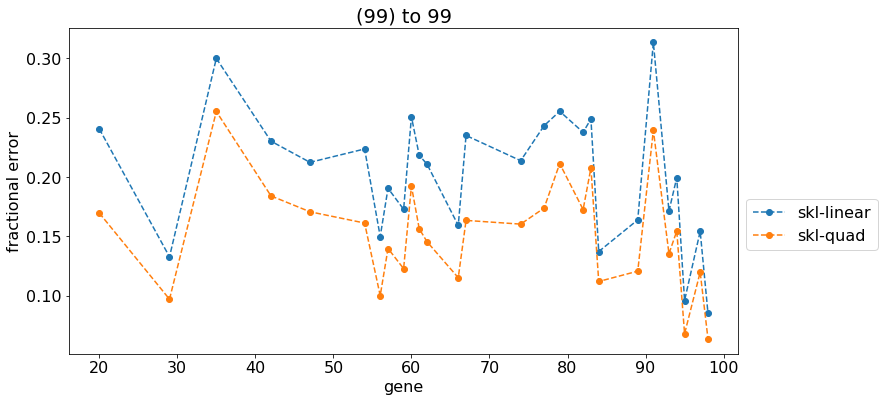

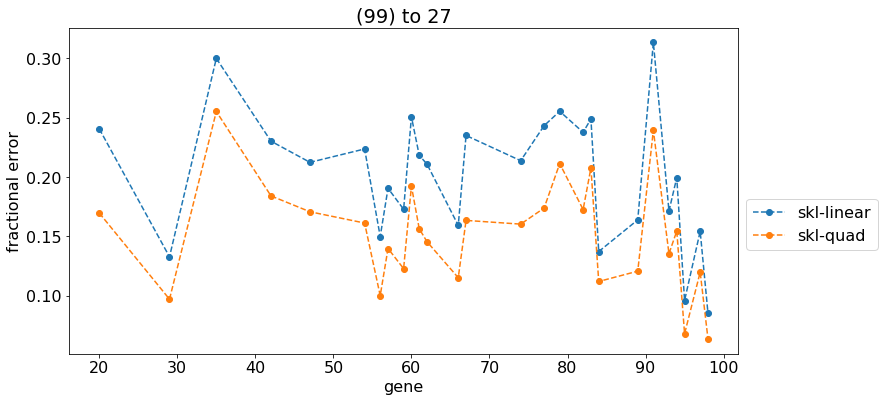

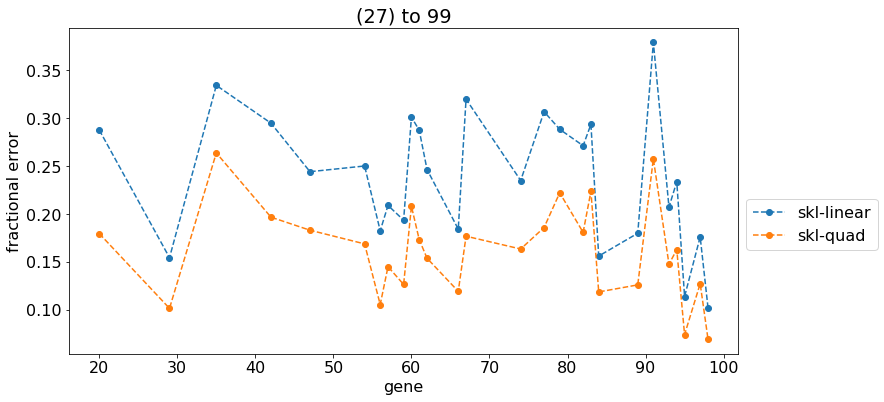

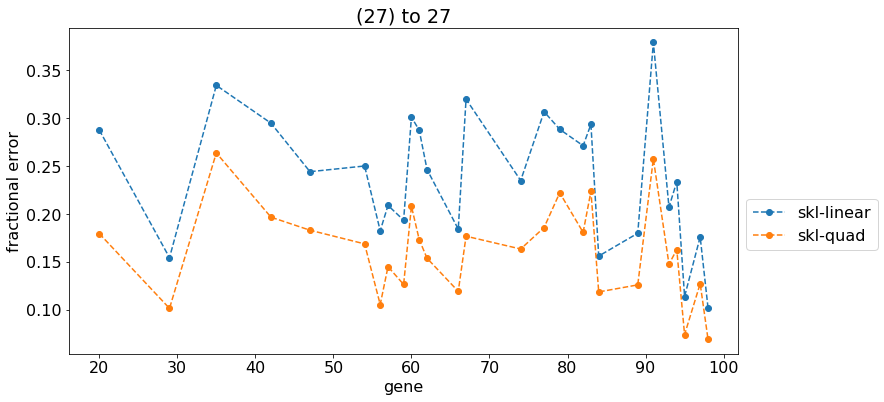

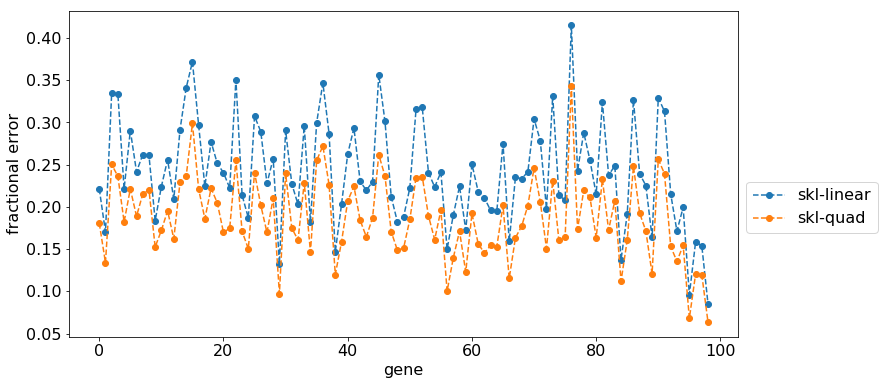

In [14]:
with open('./pickles/skl_linear.pkl', 'rb') as f:
    skl_linear = pickle.load(f)
with open('./pickles/skl_quad.pkl', 'rb') as f:
    skl_quad = pickle.load(f)

labels=['(99) to 99', '(99) to 27', '(27) to 99', '(27) to 27']
    
for i in range(4):
    plt.figure(figsize=(12,6))
    if i == 0 or i == 2:
        plt.plot(comp_ind, skl_linear[i][0][comp_ind], 'o--', label='skl-linear')
        plt.plot(comp_ind, skl_quad[i][0][comp_ind], 'o--', label='skl-quad')
    else:
        plt.plot(comp_ind, skl_linear[i][0], 'o--', label='skl-linear')
        plt.plot(comp_ind, skl_quad[i][0], 'o--', label='skl-quad')
    plt.title(labels[i])
    plt.legend(bbox_to_anchor=(1,0.5))
    plt.xlabel('gene')
    plt.ylabel('fractional error')
    plt.show()
plt.figure(figsize=(12,6))
plt.plot(range(99), skl_linear[0][0], 'o--', label='skl-linear')
plt.plot(range(99), skl_quad[0][0], 'o--', label='skl-quad')
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('gene')
plt.ylabel('fractional error')
plt.show()

### skl-quad comparisons

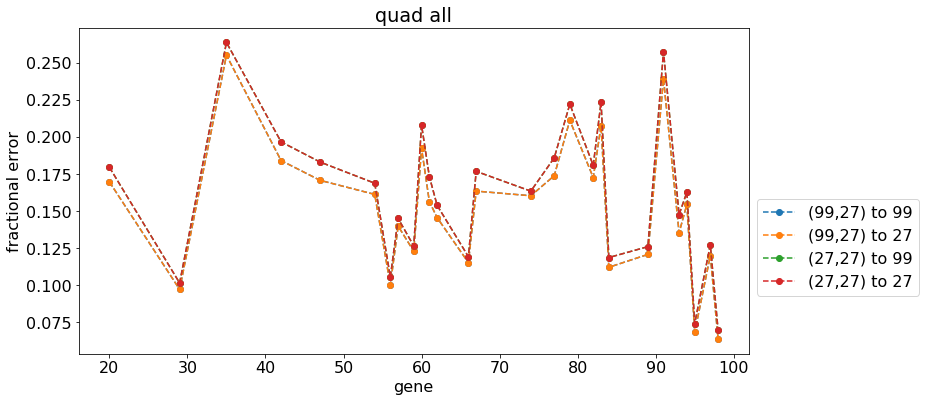

In [15]:
plt.figure(figsize=(12,6))
labels=['(99,27) to 99', '(99,27) to 27', '(27,27) to 99', '(27,27) to 27']
for i in range(4):
    if i == 0 or i == 2:
#         plt.plot(comp_ind, skl_linear[i][0][comp_ind], 'o--', label='skl-linear')
        plt.plot(comp_ind, skl_quad[i][0][comp_ind], 'o--', label=labels[i])
    else:
#         plt.plot(comp_ind, skl_linear[i][0], 'o--', label='skl-linear')
        plt.plot(comp_ind, skl_quad[i][0], 'o--', label=labels[i])
    plt.title('quad all')
    plt.legend(bbox_to_anchor=(1,0.5))
    plt.xlabel('gene')
    plt.ylabel('fractional error')
plt.show()

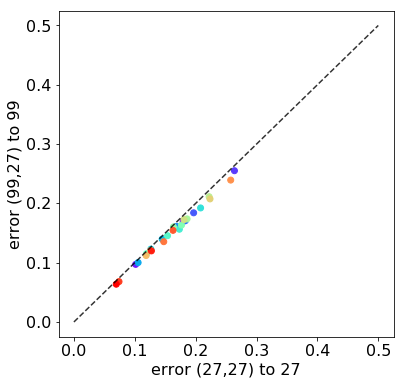

r2 score =  0.95640805937185


In [16]:
import matplotlib.cm as cm
plt.figure(figsize=(6,6))
plt.scatter(skl_quad[3][0], skl_quad[0][0][comp_ind], color=cm.rainbow(np.linspace(0,1,27)))
plt.plot([0,0.5],[0,0.5],'k--', alpha=0.8)
plt.ylabel('error (99,27) to 99')
plt.xlabel('error (27,27) to 27')
plt.show()

import sklearn.metrics
r2score = sklearn.metrics.r2_score(skl_quad[3][0], skl_quad[0][0][comp_ind])
print('r2 score = ', r2score)

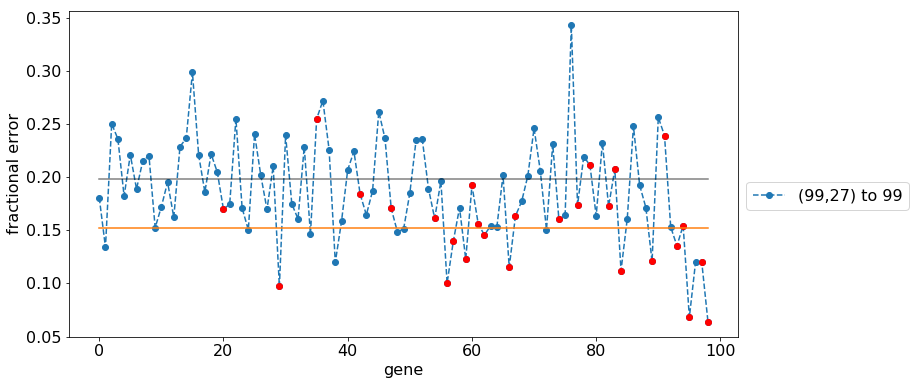

In [17]:
plt.figure(figsize=(12,6))
plt.plot(range(99), skl_quad[0][0], 'o--', label='(99,27) to 99')
plt.plot(comp_ind, skl_quad[0][0][comp_ind], 'ro')
plt.plot([0,98], [np.mean(skl_quad[0][0][comp_ind]),np.mean(skl_quad[0][0][comp_ind])])
# plt.plot([0,98], [np.mean(skl_quad[0][0][comp_ind])-np.std(skl_quad[0][0][comp_ind]),\
#                   np.mean(skl_quad[0][0][comp_ind])-np.std(skl_quad[0][0][comp_ind])],'k-', alpha=0.5)
plt.plot([0,98], [np.mean(skl_quad[0][0][comp_ind])+np.std(skl_quad[0][0][comp_ind]),\
                  np.mean(skl_quad[0][0][comp_ind])+np.std(skl_quad[0][0][comp_ind])], 'k-', alpha=0.5)
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('gene')
plt.ylabel('fractional error')
plt.show()

### sanity check

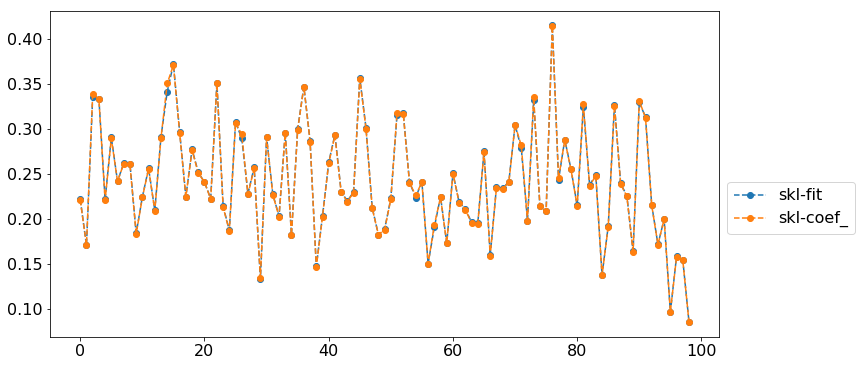

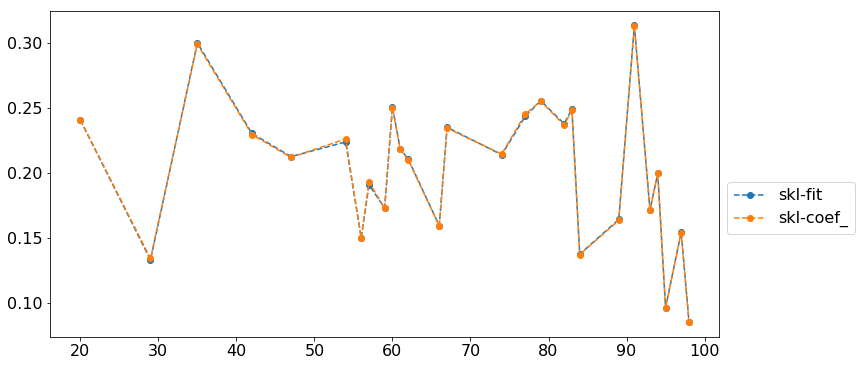

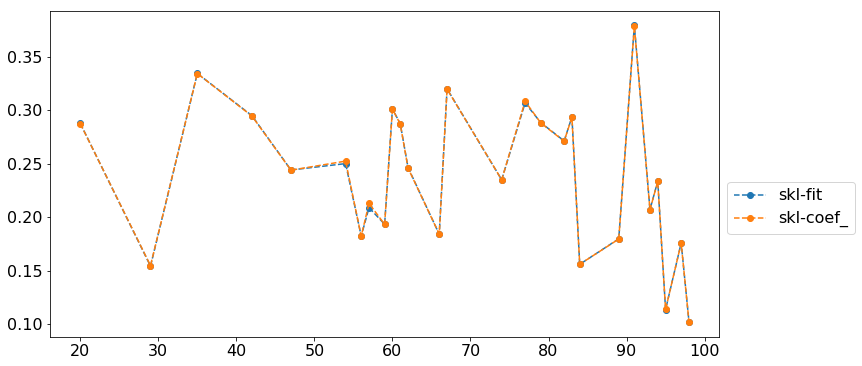

In [18]:
y_actual = all_init + all_diff
y_actual_sum_sq = y_actual_sum_sq = np.sum(np.abs(y_actual)**2, axis=0)
y_pred = all_init + all_init.dot(np.mean(skl_linear[0][-2], axis=0)) + np.mean(skl_linear[0][-1], axis=0)
error = (np.sum(np.abs(y_pred - y_actual)**2, axis=0)/y_actual_sum_sq)**(1/2)
plt.figure(figsize=(12,6))
plt.plot(range(99), skl_linear[0][0], 'o--', label='skl-fit')
plt.plot(range(99), error, 'o--', label='skl-coef_')
plt.legend(bbox_to_anchor=(1,0.5))

y_actual = comp_init + comp_diff
y_actual_sum_sq = np.sum(np.abs(y_actual)**2, axis=0)
y_pred = comp_init + all_init.dot(np.mean(skl_linear[1][-2], axis=0)) + np.mean(skl_linear[1][-1], axis=0)
error = (np.sum(np.abs(y_pred - y_actual)**2, axis=0)/y_actual_sum_sq)**(1/2)
plt.figure(figsize=(12,6))
plt.plot(comp_ind, skl_linear[1][0], 'o--', label='skl-fit')
plt.plot(comp_ind, error, 'o--', label='skl-coef_')
plt.legend(bbox_to_anchor=(1,0.5))

y_actual = comp_init + comp_diff
y_actual_sum_sq = y_actual_sum_sq = np.sum(np.abs(y_actual)**2, axis=0)
y_pred = comp_init + comp_init.dot(np.mean(skl_linear[3][-2], axis=0)) + np.mean(skl_linear[3][-1], axis=0)
error = (np.sum(np.abs(y_pred - y_actual)**2, axis=0)/y_actual_sum_sq)**(1/2)
plt.figure(figsize=(12,6))
plt.plot(comp_ind, skl_linear[3][0], 'o--', label='skl-fit')
plt.plot(comp_ind, error, 'o--', label='skl-coef_')
plt.legend(bbox_to_anchor=(1,0.5))

plt.show()